# Definition - BGs within MSAs
## Boston Metro Area 

In [1]:
#import functions
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

#censusdis
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
import censusdis.values as cev
import censusdis.geography as cgeo
from censusdis.states import STATE_MA
import censusdis.states as states
from censusdis.maps import ShapeReader, plot_us_boundary
import censusdis.maps as cmap


# Make sure it is there.
from censusdis.values import ALL_SPECIAL_VALUES



In [2]:
#standard packages
import pandas as pd
import numpy as np
import math
from math import pi, sqrt
import matplotlib.pyplot as plt
# import pygwalker as pyg

# import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime
import time
# from tqdm import tqdm, trange

#gis packages
import osmnx as ox
import logging as lg
ox.settings.log_console=True #use cache to avoid overloading the server
# ox.settings.memory_cache=True #use cache to avoid overloading the server
ox.settings.memory = 4294967296 #set memory cache to 4GB

from shapely.geometry import Point
import folium
import networkx as nx
## future libaries
# import contextily as cx
# import fiona
# from pandana.loaders import osm
# import momepy
# import missingno as msno
# from us import states
# import imageio

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

pd.options.display.max_columns = None # display all columns
pd.options.display.max_rows = None # display all rows

In [ ]:
# import variables file
acs5 = pd.read_csv('C:/Users/jerem/OneDrive/Documents/Git Projects/MeridianXYZ/data/census/ACS Variables.csv')

# pick variables from the "general model" file
acs5 = acs5[acs5['General Model'] == 1].reset_index().drop(['index'], axis=1)
acs5.head()

# Gather Census Geometry and Data

In [ ]:
# Variables
CENSUS_API_KEY = "781655d3b92f252d48d8acae0f5669dddf3cb9a4"
DATASET = 'acs/acs5'

VARIABLE = "B01003_001E" # total population
VARIABLE_NAME = 'Total Population'
VARIABLES = ["NAME", VARIABLE]

YEAR = 2022 # for data year
YEAR_geo = 2020 # for cbsa geometry

CBSAS = ["14460"]

reader = ShapeReader(year=YEAR)

In [ ]:
# function
def bgs_in_cbsas(DATASET, VARIABLE, VARIABLES, YEAR, YEAR_geo, CBSAS):
    """

    Create GEO_df and plot BGs in CBSAs

    gdf_cbsa_bg_data: dataset of bgs
    gdf_states_in_cbsas: state boundaries of the cbsa
    gdf_cbsa: the specific cbsa, used to get the name of the cbsa, and total boundary


    """
    # Download data from CBSA (has no geometry)
    gdf_cbsa = ced.download(
        DATASET,
        YEAR,
        VARIABLES,
        metropolitan_statistical_area_micropolitan_statistical_area = ["35620"], # New York, New Jersy, Conneticut
        # metropolitan_division = '*',
        # state_or_part = '*',
        # county = '*',
        with_geometry=True,
        api_key=CENSUS_API_KEY
        )
    
    # Download CBSA (with geometry)
    gdf_cbsa_geo = ced.download(
        DATASET,
        YEAR_geo,
        ['NAME'],
        metropolitan_statistical_area_micropolitan_statistical_area = CBSAS,
        # metropolitan_division = '*',
        # state_or_part = '*',
        # county = '*',
        with_geometry=True,
        api_key=CENSUS_API_KEY,
    )

    # Merge datasets together
    gdf_cbsa['geometry'] = gdf_cbsa_geo['geometry']

    # Download Blockgroup Data within CBSA
    gdf_cbsa_bg_data = ced.contained_within(
        metropolitan_statistical_area_micropolitan_statistical_area=CBSAS,
        ).download(
        DATASET,
        YEAR_geo,
        VARIABLES,
        with_geometry=True,
        set_to_nan=True,
        state="*",
        block_group="*",
        api_key=CENSUS_API_KEY,
    )
    
    # download all states
    gdf_state = ced.download(
        DATASET,
        YEAR,
        ["NAME"],
        state=states.ALL_STATES_DC_AND_PR,
        with_geometry=True,
        api_key=CENSUS_API_KEY,
    )

    # get unique states intersecting CBSAs
    states_covered = gdf_cbsa_bg_data["STATE"].unique()
    
    # clip states with CBSA using the code above
    gdf_states_in_cbsas = gdf_cbsa.overlay(
        gdf_state[gdf_state["STATE"].isin(states_covered)],
        how="intersection",
        keep_geom_type=True,
    )

    return gdf_cbsa_bg_data, gdf_states_in_cbsas, gdf_cbsa

In [19]:
bgs_cbsa, state_boarders, gdf_cbsa_name = bgs_in_cbsas(DATASET, VARIABLE, VARIABLES, YEAR, YEAR_geo, CBSAS)
# bgs_cbsa.head()

Text(0.5, 1.0, 'Total Population by Block Group in New York-Newark-Jersey City, NY-NJ-PA Metro Area')

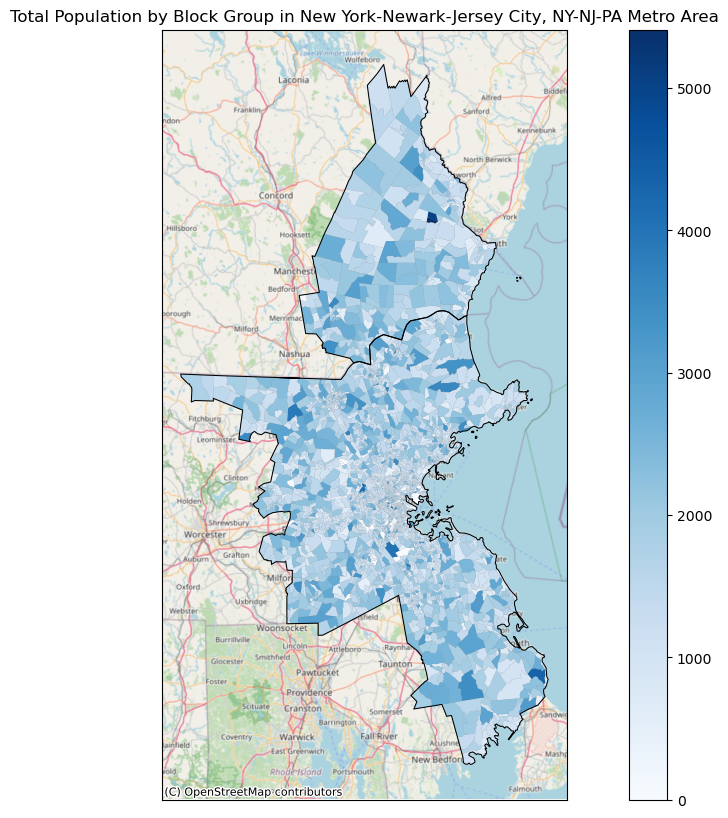

In [20]:
ax = cem.plot_map(bgs_cbsa, with_background = True, color="grey", figsize=(16, 10))

ax = cem.plot_map(
    bgs_cbsa, TOTAL_POPULATION_VARIABLE, cmap="Blues", ax=ax, legend=True
)

ax = cem.plot_map(state_boarders.boundary, ax=ax, color="black", linewidth=0.75)

cbsa_name = ",".join(gdf_cbsa_name["NAME"])

ax.set_title(f"{VARIABLE_NAME} by Block Group in {cbsa_name}")